In [2]:

import pandas as pd

In [ ]:
# Удалим дубли (одна и та же пара user-item может прийти из разных источников) — хотим сохранить все источники,
# поэтому агрегируем ниже, но для начала оставим уникальные пары

candidates = candidates.drop_duplicates(subset=["user_id", "item_id", "source", "src_score"])

In [ ]:
#python3 -m pip config set global.break-system-packages true

In [4]:
candidates = pd.read_parquet("candidates_slean.parquet")

In [3]:
events_test = pd.read_parquet("events_test.parquet")

In [6]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-23").date()

split_date_for_labels_idx = events_test["started_at"].dt.date < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy() 

In [7]:
events_labels["user_id"].nunique()

680623

In [8]:
events_labels["target"] = 1
candidates = candidates.merge(
    events_labels[["user_id", "item_id", "target"]], 
    on=["user_id", "item_id"],
    how="left"
    )

In [9]:
candidates.shape

(220216551, 5)

In [10]:
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [11]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [12]:
candidates_to_sample.shape

(67280861, 5)

In [13]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    # берём все положительные примеры
    candidates_to_sample.query("target == 1"),
    # и случайно выбираем по 4 негатива на пользователя
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(min(len(x), negatives_per_user), random_state=0)) \
        .reset_index(drop=True)
    ]) 

In [14]:
candidates_for_train.head(6)

,user_id,item_id,source,src_score,target
509,10,45499814,global_top,NaN,1
1014,15,65851540,global_top,NaN,1
1024,15,57921154,global_top,NaN,1
1065,15,76434671,global_top,NaN,1
1097,15,75642961,global_top,NaN,1
1401,23,33311009,global_top,NaN,1


- В merge указываем on=["user_id", "item_id"], how="left".
- Для негативов берём min(len(x), negatives_per_user), чтобы не упасть, если у пользователя меньше 4 отрицательных примеров.
- Все позитивы включаем полностью.

In [18]:
candidates_for_train.to_parquet('candidates_for_train.parquet')

#### добавим проверку, что у нас всё получилось правильно:

In [17]:
# проверка: для каждого пользователя должно быть хотя бы 1 положительный пример
positive_counts = candidates_for_train.query("target == 1").groupby("user_id")["target"].count()
print("Всего пользователей с положительными примерами:", positive_counts.shape[0])

# проверка: сколько у каждого пользователя отрицательных примеров
negative_counts = candidates_for_train.query("target == 0").groupby("user_id")["target"].count()

print("Минимальное число негативов на пользователя:", negative_counts.min())
print("Среднее число негативов на пользователя:", negative_counts.mean())
print("Максимальное число негативов на пользователя:", negative_counts.max())

# финальная проверка: суммарное распределение
print(candidates_for_train["target"].value_counts())

Всего пользователей с положительными примерами: 230589
Минимальное число негативов на пользователя: 4
Среднее число негативов на пользователя: 4.0
Максимальное число негативов на пользователя: 4
target
0    922356
1    554764
Name: count, dtype: int64


In [ ]:
candidates_for_train.to_parquet("candidates_for_train.parquet")

#### Обучение модели
Выше были подготовлены все нужные артефакты для обучения модели ранжирования. Выполним код, чтобы обучить модель.

In [20]:
candidates_for_train.head()

,user_id,item_id,source,src_score,target
509,10,45499814,global_top,NaN,1
1014,15,65851540,global_top,NaN,1
1024,15,57921154,global_top,NaN,1
1065,15,76434671,global_top,NaN,1
1097,15,75642961,global_top,NaN,1


In [21]:
from catboost import CatBoostClassifier, Pool

# задаём имена колонок признаков и таргета
features = ['src_score']
target = 'target'

# создаем пул объектов
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0
)

# тренируем модель
cb_model.fit(train_data) 

0:	learn: 0.6589934	total: 96.6ms	remaining: 1m 36s
100:	learn: 0.5701159	total: 3.4s	remaining: 30.2s
200:	learn: 0.5700806	total: 6.75s	remaining: 26.8s
300:	learn: 0.5700544	total: 10.1s	remaining: 23.4s
400:	learn: 0.5700549	total: 13.3s	remaining: 19.9s
500:	learn: 0.5700496	total: 16.5s	remaining: 16.4s
600:	learn: 0.5700463	total: 19.5s	remaining: 13s
700:	learn: 0.5700443	total: 22.7s	remaining: 9.69s
800:	learn: 0.5700432	total: 25.8s	remaining: 6.42s
900:	learn: 0.5700435	total: 28.9s	remaining: 3.17s
999:	learn: 0.5700414	total: 32.1s	remaining: 0us


#### Сохраним модель CatBoostClassifier

In [22]:
cb_model.save_model("models/cb_model.cbm")

In [23]:
train_data.quantize()
train_data.save('models/cb_train_data.bin')

Теперь можно получить финальные рекомендации, используя обученную модель, сохранённую в переменной cb_model.
#### Подготовка кандидатов для рекомендаций
Представим, что натренированная модель используется только некоторое время спустя, когда уже появились новые рекомендации (кандидаты) от базовых генераторов, обученных на объединении событий из events_train и events_label.
#### Задание 4 из 6
Надо, чтобы в candidates_to_rank попали кандидаты от обоих базовых генераторов подобно тому, как это было сделано для фазы тренировки выше.

In [24]:
# загружаем первоначальных кандидатов
candidates_to_rank = pd.read_parquet("candidates_slean.parquet")

In [25]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test["user_id"].drop_duplicates())]
print(len(candidates_to_rank)) 

220216551


#### Ранжирование кандидатов для рекомендаций
Применим обученную ранжирующую модель к кандидатам для рекомендаций. Таргет уже не нужен, поскольку мы будем применять модель в режиме инференса.

Вызовем модель и получим для каждого пользователя топ-100 рекомендаций — значение rank выставим не более ста.

In [26]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

In [27]:
predictions

array([[0.67962811, 0.32037189],
       [0.67962811, 0.32037189],
       [0.67962811, 0.32037189],
       ...,
       [0.99495471, 0.00504529],
       [0.99495471, 0.00504529],
       [0.994541  , 0.005459  ]])

In [28]:
candidates_to_rank["cb_score"] = predictions[:, 1]

In [29]:
candidates_to_rank.head()

,user_id,item_id,source,src_score,cb_score
0,3,53404,global_top,NaN,0.320372
1,3,33311009,global_top,NaN,0.320372
2,3,178529,global_top,NaN,0.320372
3,3,35505245,global_top,NaN,0.320372
4,3,24692821,global_top,NaN,0.320372


In [30]:
# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

In [31]:
candidates_to_rank.head()

,user_id,item_id,source,src_score,cb_score,rank
9,3,48591706,personal_als,0.216894,0.607424,1
10,3,39307896,personal_als,0.216763,0.607424,2
11,3,44184116,personal_als,0.216029,0.607424,3
7,3,57921154,personal_als,0.226330,0.607342,4
5,3,39946957,personal_als,0.249099,0.604681,5


Получим топ-100 самых релевантных рекомендация для каждого пользователя, используя обученную модель.

In [32]:
max_recommendations_per_user = 100
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user").copy()

In [33]:
final_recommendations

,user_id,item_id,source,src_score,cb_score,rank
9,3,48591706,personal_als,0.216894,0.607424,1
10,3,39307896,personal_als,0.216763,0.607424,2
11,3,44184116,personal_als,0.216029,0.607424,3
7,3,57921154,personal_als,0.226330,0.607342,4
5,3,39946957,personal_als,0.249099,0.604681,5
...,...,...,...,...,...,...
75286988,1374582,72340123,personal_als,0.093547,0.551333,96
75286989,1374582,54501382,personal_als,0.093387,0.551333,97
75286990,1374582,38852316,personal_als,0.093096,0.551333,98
75286991,1374582,58910396,personal_als,0.093083,0.551333,99


In [34]:
final_recommendations["source"]

9           personal_als
10          personal_als
11          personal_als
7           personal_als
5           personal_als
                ...     
75286988    personal_als
75286989    personal_als
75286990    personal_als
75286991    personal_als
75286992    personal_als
Name: source, Length: 78352500, dtype: object

In [35]:
candidates_to_rank["source"].unique()

array(['personal_als', 'global_top', 'i2i'], dtype=object)

In [36]:
candidates_to_rank.shape

(220216551, 6)

In [37]:
final_recommendations["source"].unique()

array(['personal_als', 'global_top', 'i2i'], dtype=object)

In [38]:
final_recommendations.shape

(78352500, 6)

In [39]:
final_recommendations.to_parquet("final_recommendations.parquet")

In [40]:
candidates_to_rank.to_parquet("candidates_to_rank.parquet")

#### Валидация

Для валидации применим recall и precision. Считать их можно, как для базовых генераторов, так и для ранжирующей модели.

In [41]:
events_train = pd.read_parquet("events_train.parquet")

In [42]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common 

In [43]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall 

In [44]:
events_inference = pd.concat([events_train, events_labels])

cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

# вычисляем метрики
cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

Common users: 606174
precision: 0.004, recall: 0.005


#### Добавляем признаки 

Загрузка данных

In [45]:
items = pd.read_parquet("items.parquet")

In [46]:
items = items.rename(columns={'track_id':'item_id'})

In [47]:
items.head()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop]


In [49]:
events_train = pd.read_parquet("events_train.parquet")

- Популярность трека (из взаимодействий)

In [51]:
track_popularity = (
    events_train.groupby("item_id")["user_id"]
    .count()
    .rename("track_play_count")
)

In [52]:
track_popularity

item_id
26            5
38            8
135          16
136           7
138          17
             ..
101478482     2
101490148    28
101493057     4
101495927     7
101521819    15
Name: track_play_count, Length: 999695, dtype: int64

In [53]:
items = items.merge(track_popularity, on="item_id", how="left")

In [54]:
items.head()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_play_count
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",5.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",8.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],16.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],7.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],17.0


- Простые количественные признаки

In [55]:
items["n_albums"] = items["albums"].apply(len)
items["n_artists"] = items["artists"].apply(len)
items["n_genres"] = items["genres"].apply(len)

In [56]:
items.head()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_play_count,n_albums,n_artists,n_genres
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",5.0,2,1,2
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",8.0,2,1,2
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],16.0,3,1,1
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],7.0,3,1,1
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],17.0,10,1,1


In [57]:
items.tail()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_play_count,n_albums,n_artists,n_genres
999995,101478482,[21399811],[5540395],"[3, 75]",На лицо,[На лицо],[FLESH],"[rusrap, rap]",2.0,1,1,2
999996,101490148,[21403052],[9078726],"[11, 20]",Без капли мысли,[Без капли мысли],[Даня Милохин],"[pop, ruspop]",28.0,1,1,2
999997,101493057,[21403883],[11865715],"[44, 75]",SKITTLES,[SKITTLES],[WhyBaby?],"[foreignrap, rap]",4.0,1,1,2
999998,101495927,[21404975],[4462686],"[3, 75]",Москва,[Москва],[Yanix],"[rusrap, rap]",7.0,1,1,2
999999,101521819,[21414638],[5056591],"[3, 75]",Вокзал,[Вокзал],[Джарахов],"[rusrap, rap]",15.0,1,1,2


- частота встречаемости артистов / жанров / альбомов

In [58]:
# частота по артистам
artist_freq = (
    items.explode("artists")
    .groupby("artists")["item_id"]
    .count()
    .rename("artist_track_count")
)

In [59]:
items = items.merge(
    items.explode("artists")[["item_id", "artists"]]
    .merge(artist_freq, on="artists")
    .groupby("item_id")["artist_track_count"]
    .mean()
    .reset_index(),
    on="item_id",
    how="left"
)

In [60]:
items.head()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_play_count,n_albums,n_artists,n_genres,artist_track_count
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",5.0,2,1,2,2.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",8.0,2,1,2,2.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],16.0,3,1,1,14.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],7.0,3,1,1,14.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],17.0,10,1,1,14.0


In [61]:
# частота по жанрам
genre_freq = (
    items.explode("genres")
    .groupby("genres")["item_id"]
    .count()
    .rename("genre_track_count")
)

In [62]:
items = items.merge(
    items.explode("genres")[["item_id", "genres"]]
    .merge(genre_freq, on="genres")
    .groupby("item_id")["genre_track_count"]
    .mean()
    .reset_index(),
    on="item_id",
    how="left"
)

In [63]:
items.head()

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_play_count,n_albums,n_artists,n_genres,artist_track_count,genre_track_count
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",5.0,2,1,2,2.0,101916.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",8.0,2,1,2,2.0,101916.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],16.0,3,1,1,14.0,166285.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],7.0,3,1,1,14.0,166285.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],17.0,10,1,1,14.0,166285.0


In [64]:
events_train.head(3)

,user_id,item_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21


Добавим поведенческие фичи:
- количество взаимодействий на пользователя (метрика активности пользователя)

In [65]:
user_n_interactions = (
    events_train.groupby("user_id")["item_id"]
    .count()
    .rename("user_n_interactions")
    .reset_index()
)

In [66]:
user_n_interactions

,user_id,user_n_interactions
0,0,26
1,1,36
2,2,14
3,3,32
4,4,244
...,...,...
1342561,1374578,9
1342562,1374579,24
1342563,1374580,277
1342564,1374581,488


In [68]:
events_train = events_train.merge(user_n_interactions, on="user_id", how="left")

- количество уникальных треков на пользователя (для понимания «широкий» или «узкий» вкус у пользователя)

In [ ]:
user_unique_tracks = (
    events_train.groupby("user_id")["item_id"]
    .nunique()
    .rename("user_n_unique_tracks")
    .reset_index()
)

In [100]:
user_unique_tracks

,user_id,user_n_unique_tracks
0,0,26
1,1,36
2,2,14
3,3,32
4,4,244
...,...,...
1342561,1374578,9
1342562,1374579,24
1342563,1374580,277
1342564,1374581,488


In [69]:
events_train = events_train.merge(user_unique_tracks, on="user_id", how="left")

- Временные признаки

In [71]:
events_train["started_at"] = pd.to_datetime(events_train["started_at"])
events_train["week_day"] = events_train["started_at"].dt.dayofweek
events_train["month"] = events_train["started_at"].dt.month

- частоты прослушиваний по времени

In [72]:
# частоты прослушиваний по времени
user_weekday_ratio = (
    events_train.groupby("user_id")["week_day"]
    .apply(lambda x: (x < 5).mean())  # доля будних дней
    .rename("user_weekday_ratio")
    .reset_index()
)

In [73]:
user_weekday_ratio

,user_id,user_weekday_ratio
0,0,0.730769
1,1,0.666667
2,2,0.857143
3,3,0.718750
4,4,0.750000
...,...,...
1342561,1374578,0.666667
1342562,1374579,0.583333
1342563,1374580,0.714801
1342564,1374581,0.715164


In [74]:
events_train = events_train.merge(user_weekday_ratio, on="user_id", how="left")

In [75]:
# сохраним временную копию на диск
events_train.to_parquet("events_train_features.parquet")

- «cвежесть» пользователя (cколько дней прошло между первым и последним прослушиванием)

In [ ]:
user_activity_span = (
    events_train.groupby("user_id")["started_at"]
    .agg(["min", "max"])
    .assign(user_active_days=lambda df: (df["max"] - df["min"]).dt.days)
    [["user_active_days"]]
    .reset_index()
)

In [7]:
user_activity_span

,user_id,user_active_days
0,0,60
1,1,47
2,2,137
3,3,312
4,4,261
...,...,...
1342561,1374578,150
1342562,1374579,62
1342563,1374580,209
1342564,1374581,246


In [ ]:
events_train = events_train.merge(user_activity_span, on="user_id", how="left")
events_train.head(5)

,user_id,item_id,track_seq,started_at,user_n_interactions,user_n_unique_tracks,week_day,month,user_weekday_ratio,user_active_days
0,0,99262,1,2022-07-17,26,26,6,7,0.730769,60
1,0,589498,2,2022-07-19,26,26,1,7,0.730769,60
2,0,590262,3,2022-07-21,26,26,3,7,0.730769,60
3,0,590303,4,2022-07-22,26,26,4,7,0.730769,60
4,0,590692,5,2022-07-22,26,26,4,7,0.730769,60


- Количество уникальных пользователей на трек

In [82]:
track_unique_users = (
    events_train.groupby("item_id")["user_id"]
    .nunique()
    .rename("track_unique_users")
    .reset_index()
)

In [83]:
track_unique_users

,item_id,track_unique_users
0,26,5
1,38,8
2,135,16
3,136,7
4,138,17
...,...,...
999690,101478482,2
999691,101490148,28
999692,101493057,4
999693,101495927,7


- Recency (свежесть прослушивания)

In [86]:
track_last_play = (
    events_train.groupby("item_id")["started_at"]
    .max()
    .rename("track_last_play")
    .reset_index()
)

# переводим в "кол-во дней с последнего прослушивания"
last_date = events_train["started_at"].max()
track_last_play["track_recency_days"] = (
    (last_date - track_last_play["track_last_play"]).dt.days
)

In [87]:
track_last_play

,item_id,track_last_play,track_recency_days
0,26,2022-07-25,143
1,38,2022-08-25,112
2,135,2022-08-27,110
3,136,2022-08-27,110
4,138,2022-10-04,72
...,...,...,...
999690,101478482,2022-11-28,17
999691,101490148,2022-12-15,0
999692,101493057,2022-11-30,15
999693,101495927,2022-12-15,0


In [89]:
# собираем все item_features
items = (
    items
    .merge(track_unique_users, on="item_id", how="left")
    .merge(track_last_play, on="item_id", how="left")
)

In [90]:
items.head(5)

,item_id,albums,artists,genres,track_name,album_names,artist_names,genre_names,track_play_count,n_albums,n_artists,n_genres,artist_track_count,genre_track_count,track_unique_users,track_last_play,track_recency_days
0,26,"[3, 2490753]",[16],"[11, 21]",Complimentary Me,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",5.0,2,1,2,2.0,101916.0,5.0,2022-07-25,143.0
1,38,"[3, 2490753]",[16],"[11, 21]",Momma's Boy,"[Taller Children, Taller Children]",[Elizabeth & the Catapult],"[pop, folk]",8.0,2,1,2,2.0,101916.0,8.0,2022-08-25,112.0
2,135,"[12, 214, 2490809]",[84],[11],Atticus,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],16.0,3,1,1,14.0,166285.0,16.0,2022-08-27,110.0
3,136,"[12, 214, 2490809]",[84],[11],24 Hours,"[Wild Young Hearts, Wild Young Hearts, Wild Yo...",[Noisettes],[pop],7.0,3,1,1,14.0,166285.0,7.0,2022-08-27,110.0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),"[Wild Young Hearts, Wild Young Hearts, Don't U...",[Noisettes],[pop],17.0,10,1,1,14.0,166285.0,17.0,2022-10-04,72.0


In [91]:
# собираем все user_features
user_features = (
    user_n_interactions
    .merge(user_unique_tracks, on="user_id", how="left")
    .merge(user_weekday_ratio, on="user_id", how="left")
    .merge(user_activity_span, on="user_id", how="left")
)

добавляем признаки age и average_rating в кандидатов

In [ ]:
candidates_for_train = candidates_for_train.merge(
    items[["item_id", "track_play_count", "n_albums", "n_artists", "n_genres", "artist_track_count", "genre_track_count", "track_unique_users", "track_last_play","track_recency_days"]],
    on="item_id",
    how="left"
)

candidates_to_rank = candidates_to_rank.merge(
    items[["item_id", "track_play_count", "n_albums", "n_artists", "n_genres", "artist_track_count", "genre_track_count", "track_unique_users", "track_last_play","track_recency_days"]],
    on="item_id",
    how="left"
)

In [19]:
# сохраним на диск
candidates_for_train.to_parquet("candidates_for_train_features.parquet")
candidates_to_rank.to_parquet("candidates_to_rank_features.parquet")

In [ ]:
import pandas as pd
# загружаем данные
candidates_for_train = pd.read_parquet("candidates_for_train_features.parquet")
candidates_to_rank = pd.read_parquet("candidates_to_rank_features.parquet")

In [9]:
events_train_features = pd.read_parquet("events_train_features.parquet")

In [11]:
events_train_features.tail()

,user_id,item_id,track_seq,started_at,user_n_interactions,user_n_unique_tracks,week_day,month,user_weekday_ratio,user_active_days
208731247,1374582,76512143,203,2022-12-15,207,207,3,12,0.792271,38
208731248,1374582,76820953,204,2022-12-15,207,207,3,12,0.792271,38
208731249,1374582,77549370,205,2022-12-15,207,207,3,12,0.792271,38
208731250,1374582,77590298,206,2022-12-15,207,207,3,12,0.792271,38
208731251,1374582,77948998,207,2022-12-15,207,207,3,12,0.792271,38


In [ ]:
candidates_for_train = candidates_for_train.merge(
    events_train_features[["user_id", "item_id", "user_active_days"]],
    on=["user_id", "item_id"],
    how="left"
)

candidates_to_rank = candidates_to_rank.merge(
    events_train_features[["user_id", "item_id", "user_active_days"]],
    on=["user_id", "item_id"],
    how="left"
)

: 

In [27]:
candidates_for_train.head(3)

,user_id,item_id,source,src_score,target,track_play_count,n_albums,n_artists,n_genres,artist_track_count,genre_track_count,track_unique_users,track_last_play,track_recency_days,week_day,user_n_interactions,user_n_unique_tracks,month,user_weekday_ratio
0,10,45499814,global_top,NaN,1,78564.0,13.0,1.0,2.0,87.0,106496.0,78564.0,2022-12-15,0.0,NaN,NaN,NaN,NaN,NaN
1,15,65851540,global_top,NaN,1,76100.0,1.0,1.0,2.0,150.0,106496.0,76100.0,2022-12-15,0.0,NaN,NaN,NaN,NaN,NaN
2,15,57921154,global_top,NaN,1,68107.0,1.0,1.0,2.0,40.0,106496.0,68107.0,2022-12-15,0.0,NaN,NaN,NaN,NaN,NaN


In [30]:
# сохраним на диск
candidates_for_train.to_parquet("candidates_for_train_2.parquet")
candidates_to_rank.to_parquet("candidates_to_rank_2.parquet")

Обучение модели с признаками

In [2]:
import pandas as pd
# загрузка данных
candidates_for_train = pd.read_parquet("candidates_for_train_2.parquet")
candidates_to_rank = pd.read_parquet("candidates_to_rank_2.parquet")

In [17]:
candidates_for_train.tail()

,user_id,item_id,source,src_score,target,track_play_count,n_albums,n_artists,n_genres,artist_track_count,genre_track_count,track_unique_users,track_last_play,track_recency_days,week_day,user_n_interactions,user_n_unique_tracks,month,user_weekday_ratio,user_active_days
1477115,1374578,56776952,global_top,0.000000,0,48365.0,1.0,1.0,2.0,181.0,97085.0,48365.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1477116,1374582,693203,i2i,0.909025,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1970-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1477117,1374582,44184116,global_top,0.000000,0,62745.0,1.0,1.0,2.0,73.0,106496.0,62745.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1477118,1374582,56776952,global_top,0.000000,0,48365.0,1.0,1.0,2.0,181.0,97085.0,48365.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1477119,1374582,70163731,personal_als,0.091576,0,12678.0,1.0,2.0,2.0,60.0,106496.0,12678.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
candidates_for_train = candidates_for_train.fillna(0)

In [12]:
candidates_to_rank = candidates_to_rank.fillna(0)

In [16]:
candidates_for_train["track_last_play"] = pd.to_datetime(candidates_for_train['track_last_play'])

In [4]:
# задаём имена колонок признаков и таргета
features = ['src_score', 'track_play_count', 
    'n_albums', 'n_artists', 'n_genres', 'artist_track_count', 
    'genre_track_count', 'track_unique_users', 
    'track_last_play', 'track_recency_days', 'week_day', 'user_n_interactions',
    'user_n_unique_tracks', 'month', 'user_weekday_ratio', 'user_active_days']
target = 'target'

In [18]:
from catboost import CatBoostClassifier, Pool
# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

In [19]:
# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6326071	total: 91.5ms	remaining: 1m 31s
100:	learn: 0.4293965	total: 4.06s	remaining: 36.1s
200:	learn: 0.4207975	total: 8.11s	remaining: 32.2s
300:	learn: 0.4154774	total: 12.2s	remaining: 28.4s
400:	learn: 0.4120935	total: 16.4s	remaining: 24.6s
500:	learn: 0.4095322	total: 20.6s	remaining: 20.5s
600:	learn: 0.4074172	total: 24.7s	remaining: 16.4s
700:	learn: 0.4056870	total: 28.7s	remaining: 12.3s
800:	learn: 0.4043186	total: 32.7s	remaining: 8.13s
900:	learn: 0.4031615	total: 36.8s	remaining: 4.04s
999:	learn: 0.4021598	total: 40.8s	remaining: 0us


#### Сохраним модель CatBoostClassifier и тренировочные данные

In [20]:
cb_model.save_model("models/cb_model_f.cbm")
train_data.quantize()
train_data.save('models/cb_train_data_f.bin')

#### Получим топ-100 самых релевантных рекомендация для каждого пользователя, используя обученную модель.

In [22]:
candidates_to_rank["track_last_play"] = pd.to_datetime(candidates_to_rank['track_last_play'])

In [24]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

In [27]:
candidates_to_rank.head()

,user_id,item_id,source,src_score,cb_score,rank,track_play_count,n_albums,n_artists,n_genres,...,genre_track_count,track_unique_users,track_last_play,track_recency_days,week_day,user_n_interactions,user_n_unique_tracks,month,user_weekday_ratio,user_active_days
0,3,48591706,personal_als,0.216894,0.000065,1,59072.0,1.0,6.0,2.0,...,97085.0,59072.0,2022-12-15,0.0,2.0,32.0,32.0,8.0,0.71875,312.0
1,3,39307896,personal_als,0.216763,0.000023,2,49657.0,2.0,1.0,2.0,...,97085.0,49657.0,2022-12-15,0.0,4.0,32.0,32.0,6.0,0.71875,312.0
2,3,44184116,personal_als,0.216029,0.599934,3,62745.0,1.0,1.0,2.0,...,106496.0,62745.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,3,57921154,personal_als,0.226330,0.696116,4,68107.0,1.0,1.0,2.0,...,106496.0,68107.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
4,3,39946957,personal_als,0.249099,0.153356,5,65516.0,1.0,1.0,2.0,...,106496.0,65516.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [26]:
candidates_to_rank["cb_score"] = predictions[:, 1]

- проставим ранги для каждого пользователя

In [28]:
# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

Получим топ-100 самых релевантных рекомендация для каждого пользователя, используя обученную модель.

In [29]:
max_recommendations_per_user = 100
last_final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user").copy()

In [31]:
last_final_recommendations['user_id'].nunique()

783525

In [32]:
last_final_recommendations["source"].unique()

array(['global_top', 'personal_als', 'i2i'], dtype=object)

#### Проверьте оценку качества трёх типов рекомендаций: 
- топ популярных;
- персональных, полученных при помощи ALS;
- итоговых (по метрикам: recall, precision, coverage, novelty).

In [33]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall 

In [41]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common 

In [35]:
events_train = pd.read_parquet("events_train.parquet")

In [37]:
events_test = pd.read_parquet("events_test.parquet")

In [38]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-23").date()

split_date_for_labels_idx = events_test["started_at"].dt.date < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy() 

In [39]:
# для экономии ресурсов оставим события только тех пользователей, 
# для которых следует оценить рекомендации
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

In [45]:
last_final_recommendations.head()

,user_id,item_id,source,src_score,cb_score,rank,track_play_count,n_albums,n_artists,n_genres,...,genre_track_count,track_unique_users,track_last_play,track_recency_days,week_day,user_n_interactions,user_n_unique_tracks,month,user_weekday_ratio,user_active_days
124,3,57921154,global_top,0.0,0.980803,1,68107.0,1.0,1.0,2.0,...,106496.0,68107.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,3,53404,global_top,0.0,0.977726,2,110026.0,16.0,1.0,3.0,...,72196.0,110026.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,3,33311009,global_top,0.0,0.973143,3,101076.0,211.0,1.0,2.0,...,86843.0,101076.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,3,81848875,global_top,0.0,0.970797,4,51548.0,1.0,1.0,2.0,...,106496.0,51548.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,3,54798445,global_top,0.0,0.969204,5,67759.0,1.0,1.0,2.0,...,97085.0,67759.0,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
cb_events_recs_for_binary_metrics_10 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    last_final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=20)

Common users: 606174


In [52]:
cb_precision_10, cb_recall_10 = compute_cls_metrics(cb_events_recs_for_binary_metrics_10)

print(f"precision: {cb_precision_10:.3f}, recall: {cb_recall_10:.3f}")

precision: 0.006, recall: 0.016


#### Проверка важности признаков
Нужно понять, какие признаки вносят наибольший вклад в ранжирование. Алгоритм CatBoost позволяет получить такую информацию (англ. feature importance), которая генерируется во время тренировки модели. Для этого использую метод get_feature_importance().

In [53]:
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])
feature_importance 

,fi
src_score,11.254871
track_play_count,16.765127
n_albums,4.193277
n_artists,0.738457
n_genres,1.106141
artist_track_count,9.433511
genre_track_count,7.286840
track_unique_users,5.617709
track_last_play,0.055464
track_recency_days,0.057140


In [54]:
feature_importance = feature_importance.sort_values("fi", ascending=False)

print(feature_importance ) 

                             fi
user_n_interactions   19.158385
track_play_count      16.765127
month                 11.522526
src_score             11.254871
artist_track_count     9.433511
user_active_days       9.379542
genre_track_count      7.286840
track_unique_users     5.617709
n_albums               4.193277
user_weekday_ratio     2.343137
n_genres               1.106141
user_n_unique_tracks   1.087874
n_artists              0.738457
track_recency_days     0.057140
track_last_play        0.055464
week_day               0.000000


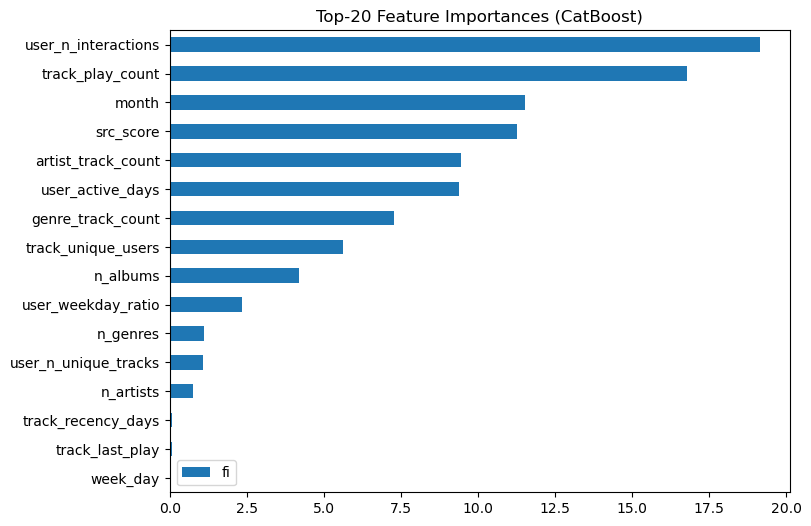

In [57]:
import matplotlib.pyplot as plt

feature_importance.head(16).plot(kind="barh", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("Top-20 Feature Importances (CatBoost)")
plt.show()

In [62]:
last_final_recommendations["source"].unique()

array(['global_top', 'personal_als', 'i2i'], dtype=object)

In [63]:
# Загружаем тестовую выборку (реальные взаимодействия)
events_test = pd.read_parquet("events_test.parquet")

# Оставляем только user_id-item_id для проверки
ground_truth = events_test[["user_id", "item_id"]].drop_duplicates()

Группируем рекомендации по пользователю. Удобно собрать рекомендации в словари:

In [65]:
recs_grouped = (
    last_final_recommendations.sort_values("rank")
    .groupby(["user_id", "source"])["item_id"]
    .apply(list)
    .reset_index()
)

In [66]:
recs_grouped.head()

,user_id,source,item_id
0,3,global_top,"[57921154, 53404, 33311009, 81848875, 54798445..."
1,3,personal_als,"[80153541, 58515506, 54400255, 33311009, 65851..."
2,4,global_top,"[48591706, 57921154, 53404, 33311009, 81848875..."
3,4,personal_als,"[41625041, 60292250, 31995925, 27353967, 24327..."
4,5,global_top,"[48591706, 57921154, 53404, 81848875, 54798445..."


Теперь у нас по каждой паре (user_id, source) есть список рекомендованных треков.

Метрики качества. Напишем функции для Recall@K, Precision@K, Coverage, Novelty:

In [67]:
import numpy as np

def recall_at_k(recommended, relevant, k=10):
    if len(relevant) == 0:
        return np.nan
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(relevant))
    return hits / len(relevant)

def precision_at_k(recommended, relevant, k=10):
    recommended_at_k = recommended[:k]
    hits = len(set(recommended_at_k) & set(relevant))
    return hits / k

def coverage(recs_df, all_items):
    recommended_items = set(recs_df["item_id"])
    return len(recommended_items) / len(all_items)

def novelty(recommended, item_popularity, k=10):
    # item_popularity = dict {item_id: popularity_count}
    rec_items = recommended[:k]
    return np.mean([-np.log2(item_popularity.get(i, 1e-6) / sum(item_popularity.values())) for i in rec_items])

Подготовим популярность треков для метрики novelty

In [68]:
item_popularity = (
    ground_truth["item_id"]
    .value_counts()
    .to_dict()
)

Считаем метрики по каждому источнику

In [70]:
results = []

all_items = last_final_recommendations["item_id"].unique()

for source in recs_grouped["source"].unique():
    source_data = recs_grouped[recs_grouped["source"] == source]

    recalls, precisions, novelties = [], [], []

    for _, row in source_data.iterrows():
        user = row["user_id"]
        recommended = row["item_id"]
        relevant = ground_truth[ground_truth["user_id"] == user]["item_id"].tolist()

        recalls.append(recall_at_k(recommended, relevant, k=10))
        precisions.append(precision_at_k(recommended, relevant, k=10))
        novelties.append(novelty(recommended, item_popularity, k=10))

    results.append({
        "source": source,
        "Recall@10": np.nanmean(recalls),
        "Precision@10": np.nanmean(precisions),
        "Coverage": coverage(source_data, all_items),
        "Novelty": np.nanmean(novelties)
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

KeyboardInterrupt: 

Подготовим ground_truth в виде словаря множеств

In [71]:
ground_truth_dict = (
    ground_truth.groupby("user_id")["item_id"]
    .apply(set)
    .to_dict()
)

Считаем Recall@K и Precision@K векторизованно

In [73]:
def calc_user_metrics(row, k=10):
    recommended = row["item_id"][:k]  # top-K
    relevant = ground_truth_dict.get(row["user_id"], set())
    if not relevant:
        return pd.Series({"recall": np.nan, "precision": np.nan})
    hits = len(set(recommended) & relevant)
    return pd.Series({
        "recall": hits / len(relevant),
        "precision": hits / k
    })

Применяем группировку по источникам

In [74]:
results = []

for source, df in recs_grouped.groupby("source"):
    metrics = df.apply(calc_user_metrics, axis=1)
    results.append({
        "source": source,
        "Recall@10": metrics["recall"].mean(skipna=True),
        "Precision@10": metrics["precision"].mean(skipna=True),
        "Coverage": df["item_id"].explode().nunique() / len(all_items),
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

         source  Recall@10  Precision@10  Coverage
0    global_top   0.006282      0.008144  0.006290
1           i2i   0.000137      0.000040  0.430018
2  personal_als   0.035874      0.029521  0.596339


#### novelty

In [149]:
# разметим каждую рекомендацию признаком listen
events_train["listen"] = True
last_final_recommendations = last_final_recommendations.merge(
    events_train[["user_id", "item_id", "listen"]], 
    on=["user_id", "item_id"], 
    how="left"
    )

In [82]:
last_final_recommendations["listen"] = last_final_recommendations["listen"].fillna(False).astype("bool")

In [152]:
# Проставим ранги внутри пользователей
last_final_recommendations = last_final_recommendations.sort_values(
    ["user_id", "cb_score"], ascending=[True, False]  # сортируем по убыванию score
)
last_final_recommendations["rank"] = last_final_recommendations.groupby("user_id").cumcount() + 1

In [ ]:
# посчитаем  Novelty@10 для каждого пользователя
novelty_10 = 1 - last_final_recommendations.query("rank <= 10").groupby("user_id")["listen"].mean()

# посчитаем средний novelty
# 4. Среднее Novelty@10
mean_novelty_10 = novelty_10.mean()

print(mean_novelty_10)

1.0


In [97]:
results.append({
        "source": "all_recommend",
        "novelty@10": mean_novelty_10,
    })

In [153]:
results

[{'source': 'global_top',
  'Recall@10': 0.006281531366131312,
  'Precision@10': 0.00814383714623018,
  'Coverage': 0.006290495061961376,
  'novelty@10': 1.0},
 {'source': 'i2i',
  'Recall@10': 0.00013671306466825296,
  'Precision@10': 4.021043460778072e-05,
  'Coverage': 0.4300182424356797,
  'novelty@10': 1.0},
 {'source': 'personal_als',
  'Recall@10': 0.03587410118959928,
  'Precision@10': 0.029521107378583256,
  'Coverage': 0.5963389318739385},
 {'source': 'all_recommend', 'novelty@10': 1.0},
 {'source': 'global_top', 'novelty@10': 1.0}]

In [ ]:
{'source': 'global_top', 'novelty@10': 1.0}

In [ ]:
# посчитаем  Novelty@10 для каждого пользователя при global_top рекомендациях
novelty_10 = 1 - last_final_recommendations.query("source == 'global_top' & rank <= 10").groupby("user_id")["listen"].mean()

# посчитаем средний novelty
# 4. Среднее Novelty@10
mean_novelty_10 = novelty_10.mean()

print(mean_novelty_10)

1.0


In [ ]:
results[0]["novelty@10"] = mean_novelty_10

In [138]:
# посчитаем  Novelty@10 для каждого пользователя при global_top рекомендациях
novelty_10 = 1 - last_final_recommendations.query("source == 'i2i' & rank <= 10").groupby("user_id")["listen"].mean()

# посчитаем средний novelty
# 4. Среднее Novelty@10
mean_novelty_10 = novelty_10.mean()

print(mean_novelty_10)

1.0


In [139]:
results[1]["novelty@10"] = mean_novelty_10

In [141]:
# посчитаем  Novelty@10 для каждого пользователя при global_top рекомендациях
novelty_10 = 1 - last_final_recommendations.query("source == 'personal_als' & rank <= 10").groupby("user_id")["listen"].mean()

# посчитаем средний novelty
# 4. Среднее Novelty@10
mean_novelty_10 = novelty_10.mean()

print(mean_novelty_10)

1.0


In [158]:
results[2]["novelty@10"] = mean_novelty_10

In [159]:
results

[{'source': 'global_top',
  'Recall@10': 0.006281531366131312,
  'Precision@10': 0.00814383714623018,
  'Coverage': 0.006290495061961376,
  'novelty@10': 1.0},
 {'source': 'i2i',
  'Recall@10': 0.00013671306466825296,
  'Precision@10': 4.021043460778072e-05,
  'Coverage': 0.4300182424356797,
  'novelty@10': 1.0},
 {'source': 'personal_als',
  'Recall@10': 0.03587410118959928,
  'Precision@10': 0.029521107378583256,
  'Coverage': 0.5963389318739385,
  'novelty@10': 1.0},
 {'source': 'all_recommend', 'novelty@10': 1.0}]

In [160]:
metrics_df2 = pd.DataFrame(results)
print(metrics_df2)

          source  Recall@10  Precision@10  Coverage  novelty@10
0     global_top   0.006282      0.008144  0.006290         1.0
1            i2i   0.000137      0.000040  0.430018         1.0
2   personal_als   0.035874      0.029521  0.596339         1.0
3  all_recommend        NaN           NaN       NaN         1.0
